In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-06 17:23:49.814251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [5]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))[::10]

In [6]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_input[i, ...] = data[...]

In [7]:
VALID_label_cate = to_categorical(VALID_label)

In [8]:
from tensorflow.keras.applications import Xception

In [24]:
model = Xception(include_top=True,
                 weights=None,
                 input_tensor=None,
                 input_shape=(128, 128, 5),
                 pooling=None,
                 classes=2,
                 classifier_activation="softmax",)

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


In [25]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-4))

In [26]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-5))

In [27]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [28]:

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'Xcept_chad'

model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

In [29]:
X_batch = np.empty((batch_size, 128, 128, 5))*np.nan
# Y_batch = np.empty((batch_size, 1))*np.nan

In [30]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
from sklearn.metrics import classification_report, auc, roc_curve

In [33]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))
        Y_batch[batch_size_half:, :] = 0
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = to_categorical(Y_batch[ind_, :])
        Y_batch = Y_batch*0.9
        Y_batch[Y_batch==0]=0.09
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    Y_pred = Y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


Validation loss improved from 1.0 to 0.3718861354831119
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5/assets
--- 198.77639651298523 seconds ---
Validation loss improved from 0.3718861354831119 to 0.35009164450075214
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5/assets
--- 193.4740068912506 seconds ---
Validation loss improved from 0.35009164450075214 to 0.3416244752666213
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5/assets
--- 193.4643280506134 seconds ---
Validation loss improved from 0.3416244752666213 to 0.2965750116607416
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5/assets
--- 190.80728816986084

KeyboardInterrupt: 

In [34]:
key = 'Xcept_chad'
model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-5))

model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

In [35]:
Y_pred = model.predict([VALID_input])
Y_pred = Y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.25366164361831767


In [36]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))
        Y_batch[batch_size_half:, :] = 0
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = to_categorical(Y_batch[ind_, :])
        Y_batch = Y_batch*0.9
        Y_batch[Y_batch==0]=0.09
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    Y_pred = Y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


Validation loss 0.3245193620838901 NOT improved
Validation loss 0.44887880917563805 NOT improved
Validation loss 0.652474112628058 NOT improved
Validation loss 0.7714807802612006 NOT improved
Validation loss 0.8062652456319492 NOT improved
Validation loss 0.6124312173814386 NOT improved
Validation loss 0.4598206688223281 NOT improved
Validation loss 0.30587445320575857 NOT improved
Validation loss 0.2539610410416089 NOT improved
Validation loss improved from 0.25366164361831767 to 0.23196898715427472
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5_tune/assets
--- 188.93584656715393 seconds ---
Validation loss improved from 0.23196898715427472 to 0.21977287553891545
save to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/Xcept_chad_pp5_tune/assets
--- 181.80476450920105 seconds ---
Validation loss improved from

KeyboardInterrupt: 

In [37]:
key = 'Xcept_chad'
model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [38]:
from sklearn.metrics import classification_report, auc, roc_curve

In [39]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [40]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_input[i, ...] = data[...]

In [41]:
filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label_skew = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label_skew)

VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_skew[i, ...] = data[...]

**Balanced verif**

In [44]:
Y_pred = model.predict([VALID_input])
Y_pred_label = Y_pred > 0.5

In [45]:
print(classification_report(Y_pred_label[:, 1].ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.96      0.72      0.83     38948
        True       0.59      0.93      0.72     16348

    accuracy                           0.78     55296
   macro avg       0.77      0.83      0.77     55296
weighted avg       0.85      0.78      0.79     55296



In [46]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred[:, 1].ravel())
auc(fpr, tpr)

0.8371623946030101

**Natural verif**

In [47]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5

In [48]:
print(classification_report(Y_pred_label[:, 1].ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96     29372
        True       0.55      0.55      0.55      2596

    accuracy                           0.93     31968
   macro avg       0.75      0.75      0.75     31968
weighted avg       0.93      0.93      0.93     31968



In [49]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred[:, 1].ravel())
auc(fpr, tpr)

0.7977736100709574

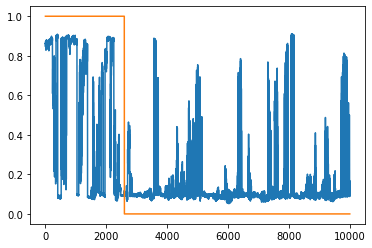

In [50]:
plt.plot(Y_pred[:, 1].ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])